In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

from torch.utils.data import TensorDataset
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

import pickle 
with open('mapping.pkl', 'rb') as file:
    mappingDict = pickle.load(file)

c:\Users\eric7\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\eric7\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- Copied model structure from training code

testOutModel Function:
- First pass the image through alexNet, then through the model (alexNet: non-tunable section)
- Converting from integer indexes back to string using the dictionary loaded through pickle

In [2]:
class preLearnedFungaV1(nn.Module):
    def __init__(self):
        super(preLearnedFungaV1, self).__init__()
        self.name = "fungaV1"
        #added anther convolution channel before fc layers
        self.conv1 = nn.Conv2d(256, 128, 3, 1, 1)
        self.fc1 = nn.Linear(128*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        #dropout implementation
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)

        #FC layers
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))

        x = self.dropout4(x)
        x = self.fc3(x)
        x = x.squeeze(1)  
        return x
def get_model_name(name, batch_size, lr, epoch):
    path = "modelStorage/model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, lr, epoch)
    return path

def testOutModel(image):
    BATCH_SIZE = 64
    LEARNING_RATE = 0.0006
    BEST_EPOCH = 90
    n = 10
    bestNet = preLearnedFungaV1()
    model_path = get_model_name("fungaV1", batch_size=BATCH_SIZE, lr=LEARNING_RATE, epoch=BEST_EPOCH)
    state = torch.load(model_path)
    bestNet.load_state_dict(state)

    featureExtraction = alexnet.features(transform(Image.open(image)))
    bestNet.eval()
    with torch.no_grad():
        output = bestNet(featureExtraction.unsqueeze(0))
    print(f"\n\n{output}")
    modelPrediction = torch.max(output, 1)
    print("\n\nModel Prediction:")

    return mappingDict[modelPrediction[1].item()]


the section below tests the model

Randomly Selected Key: Oudemansiella


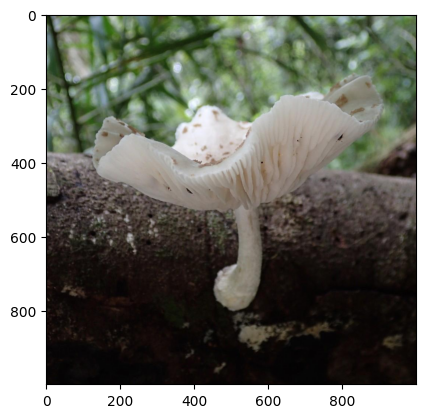



tensor([[ 3.0077,  1.8948,  0.5705,  1.2438, -2.8304, -6.4211, -6.1118,  7.7478,
          2.0013,  0.0540]])


Model Prediction:
the model classifies the mushroom as: Oudemansiella


In [9]:
import random
import matplotlib.pyplot as plt    #for displaying randomly chosen image

#Test out the function
df_test = pd.read_csv("../data/set_test.csv")
grouped_testing = df_test.groupby('Genus')['Path'].apply(list).to_dict()
mapping_testing = {key: np.array(value) for key, value in grouped_testing.items()}


#Choose A random Key
keyList = []
for key in mapping_testing.keys():
    keyList.append(key)
n = len(keyList)
randomIndex = random.randint(0, n-1)

chosenKey = keyList[randomIndex]
print(f"Randomly Selected Key: {chosenKey}")

#Choose an image from key
n = len(mapping_testing[chosenKey])
randomIndex = random.randint(0, n-1)
firstImage = mapping_testing[chosenKey][randomIndex]
img = plt.imread(firstImage) 
plt.imshow(img) 
plt.show()  


#Call the function
output = testOutModel(firstImage)
print(f"the model classifies the mushroom as: {output}")

Now doing it for multiple random genus images

In [10]:
import random
import matplotlib.pyplot as plt    #for displaying randomly chosen image

#Test out the function
df_test = pd.read_csv("../data/set_test.csv")
grouped_testing = df_test.groupby('Genus')['Path'].apply(list).to_dict()
mapping_testing = {key: np.array(value) for key, value in grouped_testing.items()}


#Choose A random Key
keyList = []
for key in mapping_testing.keys():
    keyList.append(key)
print(keyList)
n = len(keyList)

randomKeyList = []
randomImgList = []
for i in range(10):
    print(i)
    randIndex = random.randint(0, n-1)
    randKeyChosen = keyList[randIndex]
    randomKeyList.append(randKeyChosen)
    q = len(mapping_testing[randKeyChosen])
    randomIndex = random.randint(0, q-1)
    randImg = mapping_testing[randKeyChosen][randomIndex]
    randomImgList.append(randImg)

    i = 0

['Auricularia', 'Cookeina', 'Entoloma', 'Geastrum', 'Hygrocybe', 'Marasmius', 'Ophiocordyceps', 'Oudemansiella', 'Phallus', 'Trametes']
0
1
2
3
4
5
6
7
8
9


genus: Oudemansiella
../splittedImgFolder/testSet\Oudemansiella\SS PC274557_27_12_2018_Paranut_Trail_CJL_BR_270_rotate.jpg


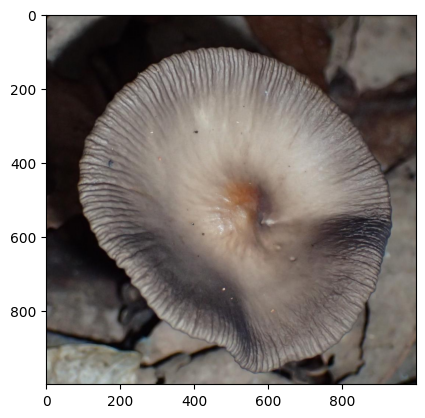



tensor([[-4.6284,  8.5330,  8.8669, -2.5844,  7.3961, -5.9995, -6.7889,  7.7018,
         -7.5384, -5.6513]])


Model Prediction:
the model classifies the mushroom as: Entoloma


In [14]:
print(f"genus: {randomKeyList[i]}")
link = randomImgList[i]
print(link)
img = plt.imread(link) 
plt.imshow(img) 
plt.show()  


#Call the function
output = testOutModel(randomImgList[i])
print(f"the model classifies the mushroom as: {output}")
i += 1

genus: Auricularia


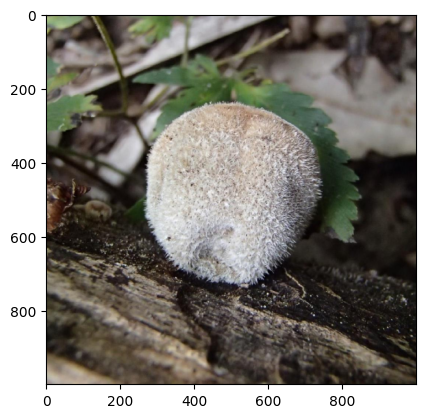



tensor([[ 4.5606,  1.1866, -2.3683,  3.4712,  6.0739, -3.7548, -2.1817, -1.5974,
         -3.1365, -1.9108]])


Model Prediction:
the model classifies the mushroom as: Hygrocybe


In [15]:
print(f"genus: {randomKeyList[i]}")
img = plt.imread(randomImgList[i]) 
plt.imshow(img) 
plt.show()  


#Call the function
output = testOutModel(randomImgList[i])
print(f"the model classifies the mushroom as: {output}")
i += 1

genus: Entoloma


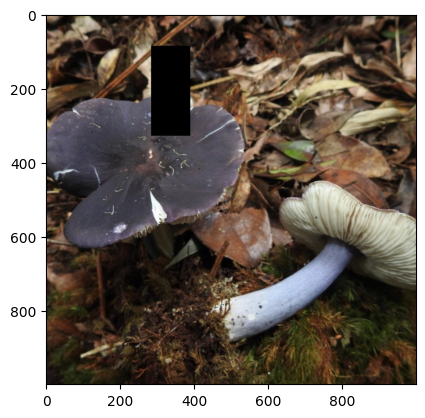



tensor([[-3.8139e+00, -3.4287e+00,  6.9082e+00,  4.6953e+00, -1.4818e+00,
         -2.6624e-03, -3.3289e+00, -2.0766e-01, -8.4190e-01,  1.9267e+00]])


Model Prediction:
the model classifies the mushroom as: Entoloma


In [16]:
print(f"genus: {randomKeyList[i]}")
img = plt.imread(randomImgList[i]) 
plt.imshow(img) 
plt.show()  


#Call the function
output = testOutModel(randomImgList[i])
print(f"the model classifies the mushroom as: {output}")
i += 1

genus: Marasmius


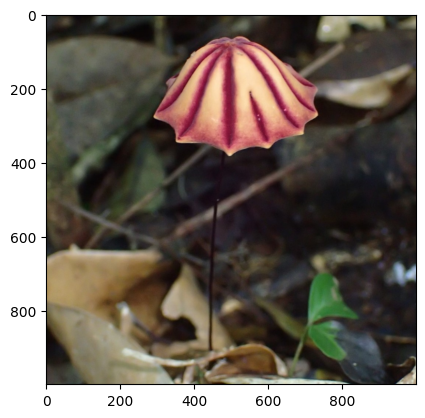



tensor([[ 0.0108, -5.5564,  1.3160,  0.5431,  2.8669, 10.7334,  0.7941, -1.3436,
         -3.6996, -4.4024]])


Model Prediction:
the model classifies the mushroom as: Marasmius


In [17]:
print(f"genus: {randomKeyList[i]}")
img = plt.imread(randomImgList[i]) 
plt.imshow(img) 
plt.show()  


#Call the function
output = testOutModel(randomImgList[i])
print(f"the model classifies the mushroom as: {output}")
i += 1